In [1]:
# Install libraries
!pip install geodatasets
!pip install pysal

# Import libraries
from datetime import datetime
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import randint
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
import geopandas as gpd
import geodatasets

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.6/141.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.1/243.1 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━

# Data loading and cleaning

## 311 complaints

In [2]:
# Download all of the 311 complaints in 2022, 2023, and 2024
# To limit the size of the download, select only unique_key, created_date, complaint_type, descriptor, incident_address, incident_zip, longitude, and latitude
all_311_complaints = pd.read_csv('https://data.cityofnewyork.us/resource/erm2-nwe9.csv?$query=SELECT%20unique_key,created_date,complaint_type,descriptor,incident_address,incident_zip,longitude,latitude%20WHERE%20date_extract_y(created_date)IN(2022,2023,2024)%20LIMIT%2050000000')
all_311_complaints.head(2)

<ipython-input-2-1d33e6c318ff>:3: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  all_311_complaints = pd.read_csv('https://data.cityofnewyork.us/resource/erm2-nwe9.csv?$query=SELECT%20unique_key,created_date,complaint_type,descriptor,incident_address,incident_zip,longitude,latitude%20WHERE%20date_extract_y(created_date)IN(2022,2023,2024)%20LIMIT%2050000000')


,unique_key,created_date,complaint_type,descriptor,incident_address,incident_zip,longitude,latitude
0,53104838,2022-01-13T11:08:19.000,Street Condition,Pothole,NaN,10466.0,-73.859682,40.889223
1,53104891,2022-01-16T15:04:28.000,Street Condition,Pothole,90 BOGART STREET,11206.0,-73.933671,40.706694


In [3]:
# Look at the data types
all_311_complaints.dtypes

,0
unique_key,int64
created_date,object
complaint_type,object
descriptor,object
incident_address,object
incident_zip,object
longitude,float64
latitude,float64


In [4]:
# Convert created_date to datetime
all_311_complaints['created_date'] = pd.to_datetime(all_311_complaints['created_date'])

# Rename 'created_date' to 'created_datetime'
all_311_complaints = all_311_complaints.rename(columns = {'created_date': 'created_datetime'})

# Extract date, month, and year from 'created_datetime'
all_311_complaints['created_date'] = all_311_complaints['created_datetime'].dt.date
all_311_complaints['created_month'] = all_311_complaints['created_datetime'].dt.month
all_311_complaints['created_year'] = all_311_complaints['created_datetime'].dt.year

In [5]:
# Look at missing values
all_311_complaints.isna().sum()

,0
unique_key,0
created_datetime,0
complaint_type,0
descriptor,308002
incident_address,400293
incident_zip,117373
longitude,153311
latitude,153311
created_date,0
created_month,0


Many of the 311 complaints are missing latitude and longitude data. I will leave these complaints in the dataset for now, since they will still be useful to analyze monthly trends.

In [6]:
all_311_complaints.columns[2:10]

Index(['complaint_type', 'descriptor', 'incident_address', 'incident_zip',
       'longitude', 'latitude', 'created_date', 'created_month'],
      dtype='object')

In [7]:
# Look at duplicate complaints
(all_311_complaints[all_311_complaints.duplicated(subset = all_311_complaints.columns[2:10], keep = False)]
 .sort_values(by = ['created_date', 'complaint_type', 'descriptor', 'latitude', 'longitude']))

,unique_key,created_datetime,complaint_type,descriptor,incident_address,incident_zip,longitude,latitude,created_date,created_month,created_year
184408,52940163,2022-01-01 22:43:26,APPLIANCE,ELECTRIC/GAS RANGE,102 SUFFOLK STREET,10002.0,-73.986219,40.718696,2022-01-01,1,2022
187283,52940833,2022-01-01 22:52:27,APPLIANCE,ELECTRIC/GAS RANGE,102 SUFFOLK STREET,10002.0,-73.986219,40.718696,2022-01-01,1,2022
184402,52942394,2022-01-01 10:48:04,Abandoned Vehicle,With License Plate,109-01 MONTEREY STREET,11429.0,-73.739217,40.709143,2022-01-01,1,2022
187874,52943087,2022-01-01 10:49:53,Abandoned Vehicle,With License Plate,109-01 MONTEREY STREET,11429.0,-73.739217,40.709143,2022-01-01,1,2022
180036,52938976,2022-01-01 14:08:38,Abandoned Vehicle,With License Plate,540 AUDUBON AVENUE,10040.0,-73.927203,40.855776,2022-01-01,1,2022
...,...,...,...,...,...,...,...,...,...,...,...
7687121,63585445,2024-12-31 16:05:00,Water System,Possible Water Main Break (Use Comments) (WA1),NaN,11230.0,-73.969967,40.609151,2024-12-31,12,2024
7681394,63573334,2024-12-31 09:11:00,Water System,Possible Water Main Break (Use Comments) (WA1),1212 EAST 58 STREET,11234.0,-73.919814,40.625066,2024-12-31,12,2024
7777254,63578458,2024-12-31 03:26:00,Water System,Possible Water Main Break (Use Comments) (WA1),1212 EAST 58 STREET,11234.0,-73.919814,40.625066,2024-12-31,12,2024
7685416,63573335,2024-12-31 16:41:00,Water System,Possible Water Main Break (Use Comments) (WA1),NaN,11367.0,-73.817172,40.727271,2024-12-31,12,2024


In [8]:
# Remove duplicate complaints
all_311_complaints = all_311_complaints.drop_duplicates(subset = all_311_complaints.columns[2:10])
all_311_complaints.reset_index(drop = True, inplace = True)

In [9]:
# Convert all_311_complaints into a GeoDataFrame in the NAD83 / New York Long Island (ftUS) coordinate reference system
all_311_complaints = gpd.GeoDataFrame(all_311_complaints,
                                      geometry = gpd.points_from_xy(all_311_complaints.longitude, all_311_complaints.latitude),
                                      crs = 'EPSG:4326')
all_311_complaints = all_311_complaints.to_crs(2263)

In [10]:
all_311_complaints.head(2)

,unique_key,created_datetime,complaint_type,descriptor,incident_address,incident_zip,longitude,latitude,created_date,created_month,created_year,geometry
0,53104838,2022-01-13 11:08:19,Street Condition,Pothole,NaN,10466.0,-73.859682,40.889223,2022-01-13,1,2022,POINT (1023047 263277.014)
1,53104891,2022-01-16 15:04:28,Street Condition,Pothole,90 BOGART STREET,11206.0,-73.933671,40.706694,2022-01-16,1,2022,POINT (1002640 196751.014)


In [11]:
# Save all_311_complaints as a .pkl file
all_311_complaints.to_pickle('all_311_complaints.pkl')

I will save each dataframe as a .pkl file and download it so I can save time later if the runtime is disconnected.

## Drop-off sites

In [12]:
# Download the sharps drop-off site data
dropoff_sites = pd.read_csv('https://data.cityofnewyork.us/resource/edk2-vkjh.csv')
dropoff_sites.head(2)

,borough,ntaname,site_type,sitename,zipcode,phonenum,days_hours,address,borocd,notes,...,councildist,senate_district,_congress_district,assembly_district,police_precints,bbl,bin,latitude,longitude,point
0,Bronx,Norwood,SYRINGE/SHARPS Drop-off,North Central Bronx Hospital,10467,718-918-5000,24/7,"3424 Kossuth Ave, Bronx, NY 10467",207,Lobby,...,11,33,15,81,52,2.033270e+09,2017787.0,40.880432,-73.881204,POINT (-73.881205418129 40.8804402931774)
1,Queens,Flushing-Willets Point,SYRINGE/SHARPS Drop-off,Union Plaza Care Center,11354,718-670-0765,10am-2pm,"33-23 Union St. Flushing, NY 11354",407,Lobby,...,20,16,6,40,109,4.049810e+09,4112550.0,40.767323,-73.826924,POINT (-73.8269253950036 40.7673312732314)


In [13]:
# Check for missing values
dropoff_sites.isna().sum()

,0
borough,0
ntaname,0
site_type,0
sitename,0
zipcode,0
phonenum,153
days_hours,153
address,0
borocd,0
notes,153


In [14]:
# Keep only the sharps dropoff sites
dropoff_sites = dropoff_sites[dropoff_sites['site_type'] == 'SYRINGE/SHARPS Drop-off']

# Keep only the relevant columns in dropoff_sites
dropoff_sites = dropoff_sites[['sitename', 'days_hours', 'latitude', 'longitude']]
dropoff_sites = dropoff_sites.reset_index(drop = True)

In [15]:
# Look at the values in the 'days_hours' column
dropoff_sites['days_hours'].value_counts()

,count
days_hours,
24/7,26
Monday-Friday 9am-5pm,19
9am-5pm,14
Monday-Friday 8am-4pm,7
10am-4pm,4
...,...
Monday-Thursday 10am-3pm,1
Monday-Sunday 11am-1pm,1
"Monday, Tuesday, Friday 9am-5pm; Wednesday 10AM-5PM; Thursday 9AM-7PM",1


The "days_hours" column is extremely messy, and cleaning it manually will take a lot of time. Therefore, I will try using Gemini to translate this column into a more quantifiable metric.

In [16]:
# Use Google's Gemini LLM to parse the 'days_hours' column into something more quantifiable

# Import the necessary libraries
from IPython.display import HTML, Markdown, display
from google.colab import userdata
from google.api_core import retry
from google import genai
from pydantic import BaseModel

# Get the Google API key
GOOGLE_API_KEY = userdata.get('google_api_key')

# Handle errors
is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})
genai.models.Models.generate_content = retry.Retry(
    predicate=is_retriable)(genai.models.Models.generate_content)

# Initialize the genAI client
client = genai.Client(api_key=GOOGLE_API_KEY)

# Define what the LLM's response should look like
class Response(BaseModel):
  logical: str
  hours_per_month: int

# For each dropoff site, ask whether the drop-off hours make sense
# If so, calculate the hours the site is open in a 28-day month
for i in range(len(dropoff_sites)):
  response = client.models.generate_content(
      model='gemini-2.0-flash',
      contents=f'''You are analyzing the opening hours of a drop-off site.
      For each set of opening hours, do the following:
      1. Determine if the description is logically interpretable.
      2. If so, estimate how many hours the site is open in a typical 28-day month.

      Respond in JSON with two fields:
      - "logical": "Yes" or "No"
      - "hours_per_month": integer (estimated total hours open in a 28-day month)

      Examples:
      Input: "24/7"
      Output: {{ "logical": "Yes", "hours_per_month": 672 }}

      Input: "Monday-Friday 8am-4pm"
      Output: {{ "logical": "Yes", "hours_per_month": 160 }}

      Input: "8"
      Output: {{ "logical": "No", "hours_per_month": 0 }}

      Now process these opening hours: {dropoff_sites.loc[i, 'days_hours']}.''',

      config={'response_mime_type': 'application/json',
              'response_schema': list[Response]})

  # Save the calculated hours
  if response.parsed[0].logical == 'Yes':
    dropoff_sites.loc[i, 'hours_per_month'] = response.parsed[0].hours_per_month
  else:
    dropoff_sites.loc[i, 'hours_per_month'] = np.nan

  # Track progress
  if i % 50 == 0:
    print(f'Progress: {i} rows')

Progress: 0 rows
Progress: 50 rows
Progress: 100 rows
Progress: 150 rows


In [17]:
# View the results
dropoff_sites[['days_hours', 'hours_per_month']]

,days_hours,hours_per_month
0,24/7,672.0
1,10am-2pm,112.0
2,9am-5pm,224.0
3,24/7,672.0
4,First and Last Friday of every month 2pm-4pm,4.0
...,...,...
188,Monday-Sunday 11am-1pm,56.0
189,"Monday, Tuesday, Friday 9am-5pm; Wednesday 10A...",144.0
190,Monday-Wednesday 9,NaN
191,Call for mobbile unit locations and hours,NaN


This method looks like it worked pretty well! Unfortunately, some of the listed hours are too ambigious to interpret, lile "Monday-Wednesday 9".

In [18]:
# Turn dropoff_sites into a GeoDataFrame
dropoff_sites = gpd.GeoDataFrame(dropoff_sites,
                                 geometry = gpd.points_from_xy(dropoff_sites.longitude, dropoff_sites.latitude),
                                 crs = 'EPSG:4326')
dropoff_sites = dropoff_sites.to_crs(2263)

In [19]:
# Save dropoff_sites as a .pkl file
dropoff_sites.to_pickle('dropoff_sites.pkl')

## Neighborhoods

In [20]:
# Download neighborhood tabulation area (NTA) data
!wget https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/bytes/neighborhood-tabulation-areas/nynta2020_25a.zip -O nta.zip
!unzip nta.zip

--2025-05-04 00:35:39--  https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/bytes/neighborhood-tabulation-areas/nynta2020_25a.zip
Resolving s-media.nyc.gov (s-media.nyc.gov)... 23.6.178.182, 2600:1406:5400:482::1500, 2600:1406:5400:48e::1500
Connecting to s-media.nyc.gov (s-media.nyc.gov)|23.6.178.182|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 989198 (966K) [application/zip]
Saving to: ‘nta.zip’

nta.zip             100%[===================>] 966.01K  2.39MB/s    in 0.4s    

2025-05-04 00:35:40 (2.39 MB/s) - ‘nta.zip’ saved [989198/989198]

Archive:  nta.zip
  inflating: nynta2020_25a/nynta2020.shp  
  inflating: nynta2020_25a/nynta2020.dbf  
  inflating: nynta2020_25a/nynta2020.shx  
  inflating: nynta2020_25a/nynta2020.prj  
  inflating: nynta2020_25a/nynta2020.shp.xml  


In [21]:
# Load the NTA data
nta = gpd.read_file('/content/nynta2020_25a/nynta2020.shp')
nta = nta.to_crs(2263)
nta.head(2)

,BoroCode,BoroName,CountyFIPS,NTA2020,NTAName,NTAAbbrev,NTAType,CDTA2020,CDTAName,Shape_Leng,Shape_Area,geometry
0,3,Brooklyn,047,BK0101,Greenpoint,Grnpt,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28919.562151,3.532181e+07,"POLYGON ((1003059.997 204572.025, 1002991.367 ..."
1,3,Brooklyn,047,BK0102,Williamsburg,Wllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28098.026805,2.885431e+07,"POLYGON ((995851.915 203199.332, 995969.192 20..."


In [22]:
# Replace NTAType integers with categories
nta['NTAType'] = nta['NTAType'].replace({'0': 'residential',
                            '5': 'other',
                            '6': 'other',
                            '7': 'cemetery',
                            '8': 'airport',
                            '9': 'park'})

In [23]:
# Convert NTA area from square feet to square miles
nta['area_sq_mi'] = nta['Shape_Area'] / 2.788e+7

## American Community Survey

In [24]:
# Download the American Community Survey data
!wget https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/population/american-community-survey/5-yr-ACS-2022.zip -O acs.zip
!unzip acs.zip

--2025-05-04 00:35:41--  https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/population/american-community-survey/5-yr-ACS-2022.zip
Resolving s-media.nyc.gov (s-media.nyc.gov)... 23.6.178.182, 2600:1406:5400:482::1500, 2600:1406:5400:48e::1500
Connecting to s-media.nyc.gov (s-media.nyc.gov)|23.6.178.182|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9389208 (9.0M) [application/zip]
Saving to: ‘acs.zip’

acs.zip             100%[===================>]   8.95M  17.3MB/s    in 0.5s    

2025-05-04 00:35:42 (17.3 MB/s) - ‘acs.zip’ saved [9389208/9389208]

Archive:  acs.zip
   creating: 5-yr ACS 2022/CityCouncilDistrict/
   creating: 5-yr ACS 2022/CityCouncilDistrict/Demographic/
  inflating: 5-yr ACS 2022/CityCouncilDistrict/Demographic/Dem_1822_CCD.xlsx  
   creating: 5-yr ACS 2022/CityCouncilDistrict/Economic/
  inflating: 5-yr ACS 2022/CityCouncilDistrict/Economic/Econ_1822_CCD.xlsx  
   creating: 5-yr ACS 2022/CityCouncilDistrict/Housing/
  inflat

In [25]:
# Load the ACS demographic data
acs_demographic = pd.read_excel('/content/5-yr ACS 2022/Neighborhood-NTA/Demographic/Dem_1822_NTA.xlsx')
acs_demographic.head(2)

,GeoType,NTAType,GeogName,GeoID,Borough,Pop_1E,Pop_1M,Pop_1C,Pop_1P,Pop_1Z,...,AsnOAsnE,AsnOAsnM,AsnOAsnC,AsnOAsnP,AsnOAsnZ,Asn2plE,Asn2plM,Asn2plC,Asn2plP,Asn2plZ
0,NTA2020,0,Greenpoint,BK0101,Brooklyn,38260,1664.0,2.6,100.0,0.0,...,9,13.0,87.8,0.5,0.7,143,114.0,48.5,7.5,5.8
1,NTA2020,0,Williamsburg,BK0102,Brooklyn,64311,2670.0,2.5,100.0,0.0,...,30,43.0,87.1,0.6,0.8,190,137.0,43.9,3.6,2.5


In [26]:
# Rename 'GeoID' to 'NTA2020'
acs_demographic = acs_demographic.rename(columns = {'GeoID': 'NTA2020'})

In [27]:
# Get Pop_1E (population estimate) for each NTA
nta = nta.merge(acs_demographic[['NTA2020', 'Pop_1E']], on = 'NTA2020')

In [28]:
# Load the ACS economic data
acs_economic = pd.read_excel('/content/5-yr ACS 2022/Neighborhood-NTA/Economic/Econ_1822_NTA.xlsx')
acs_economic.head(2)

,GeoType,NTAType,GeogName,GeoID,Borough,Pop16plE,Pop16plM,Pop16plC,Pop16plP,Pop16plZ,...,Pv400t499E,Pv400t499M,Pv400t499C,Pv400t499P,Pv400t499Z,Pv500plE,Pv500plM,Pv500plC,Pv500plP,Pv500plZ
0,NTA2020,0,Greenpoint,BK0101,Brooklyn,33601,1431.0,2.6,100.0,0.0,...,4404,592.0,8.2,11.6,1.5,20096,1295.0,3.9,52.8,2.5
1,NTA2020,0,Williamsburg,BK0102,Brooklyn,53760,2115.0,2.4,100.0,0.0,...,4381,656.0,9.1,6.8,1.0,29900,1629.0,3.3,46.6,1.6


In [29]:
# Rename 'GeoID' to 'NTA2020'
acs_economic = acs_economic.rename(columns = {'GeoID': 'NTA2020'})

In [30]:
# Get the following variables for each NTA
# CvLFUEm1P: the percent of the labor force that is unemployed
# MdHHIncE: the median household income
# PvU50P: the percent of the population with a ratio of income to poverty level < 0.5
# Pv500plP: the percent of the population with a ratio of income to poverty level > 5.00
nta = nta.merge(acs_economic[['NTA2020', 'CvLFUEm1P', 'MdHHIncE', 'PvU50P', 'Pv500plP']], on = 'NTA2020')

In [31]:
# Load the ACS housing data for NTAs
acs_housing = pd.read_excel('/content/5-yr ACS 2022/Neighborhood-NTA/Housing/Hous_1822_NTA.xlsx')
acs_housing.head(2)

,GeoType,NTAType,GeogName,GeoID,Borough,HU1E,HU1M,HU1C,HU1P,HU1Z,...,GRPI50plE,GRPI50plM,GRPI50plC,GRPI50plP,GRPI50plZ,GRPINtCE,GRPINtCM,GRPINtCC,GRPINtCP,GRPINtCZ
0,NTA2020,0,Greenpoint,BK0101,Brooklyn,19564,652.0,2.0,100.0,0.0,...,2434,444.0,11.1,17.1,3.0,548,172.0,19.1,NaN,NaN
1,NTA2020,0,Williamsburg,BK0102,Brooklyn,30539,938.0,1.9,100.0,0.0,...,4547,526.0,7.0,19.9,2.1,616,193.0,19.1,NaN,NaN


In [32]:
# Rename 'GeoID' to 'NTA2020'
acs_housing = acs_housing.rename(columns = {'GeoID': 'NTA2020'})

In [33]:
# Get the following variables for each NTA
# VacHUP: the percent of vacant housing units
# ROcHU1P: the percent of renter-occupied housing units (as opposed to owner-occupied)
# GRPI30plP: the percent of occupied units where rent is 30% or more of the household income
nta = nta.merge(acs_housing[['NTA2020', 'VacHUP', 'ROcHU1P', 'GRPI30plP']])

In [34]:
nta.head(2)

,BoroCode,BoroName,CountyFIPS,NTA2020,NTAName,NTAAbbrev,NTAType,CDTA2020,CDTAName,Shape_Leng,...,geometry,area_sq_mi,Pop_1E,CvLFUEm1P,MdHHIncE,PvU50P,Pv500plP,VacHUP,ROcHU1P,GRPI30plP
0,3,Brooklyn,047,BK0101,Greenpoint,Grnpt,residential,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28919.562151,...,"POLYGON ((1003059.997 204572.025, 1002991.367 ...",1.266923,38260,5.8,125469.0,4.1,52.8,8.0,82.2,35.1
1,3,Brooklyn,047,BK0102,Williamsburg,Wllmsbrg,residential,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28098.026805,...,"POLYGON ((995851.915 203199.332, 995969.192 20...",1.034947,64311,5.1,129838.0,7.1,46.6,7.4,83.1,42.0


In [35]:
# Save nta as a .pkl file
nta.to_pickle('nta.pkl')

## Hotels

In [36]:
# Load the hotel data
hotels = pd.read_csv('https://data.cityofnewyork.us/resource/tjus-cn27.csv?$limit=5000')
hotels.head(2)

,parid,borocode,block,lot,taxyear,street_num,street_name,postcode,bldg_class,taxclass,...,borough,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta,nta_code2
0,1000080039,1,8,39,2021,32,PEARL STREET,10004,H3,4,...,MANHATTAN,40.703235,-74.012421,101.0,1.0,9.0,1078968.0,1.000080e+09,Battery Park City-Lower Manhattan,NaN
1,1000080051,1,8,51,2021,6,WATER STREET,10004,H2,4,...,MANHATTAN,40.702744,-74.012201,101.0,1.0,9.0,1090472.0,1.000080e+09,Battery Park City-Lower Manhattan,NaN


In [37]:
# Check for missing values
hotels.isna().sum()

,0
parid,0
borocode,0
block,0
lot,0
taxyear,0
street_num,2
street_name,0
postcode,0
bldg_class,0
taxclass,0


In [38]:
# Drop duplicate hotels (hotels with same address and owner)
hotels = hotels.drop_duplicates(subset = ['street_num', 'street_name', 'postcode', 'owner_name'])
hotels = hotels.reset_index(drop = True)

In [39]:
# Keep only the relevant columns
hotels = hotels[['parid', 'latitude', 'longitude']]

# Keep only the rows with latitude and longitude data
hotels = hotels[(pd.isna(hotels['longitude']) == False) & (pd.isna(hotels['latitude']) == False)]

In [40]:
# Turn hotels into a GeoDataFrame
hotels = gpd.GeoDataFrame(hotels, geometry = gpd.points_from_xy(hotels['longitude'], hotels['latitude']), crs = 'EPSG:4326')
hotels = hotels.to_crs(epsg=2263)

In [41]:
# Save hotels as a .pkl file
hotels.to_pickle('hotels.pkl')

# Data analysis

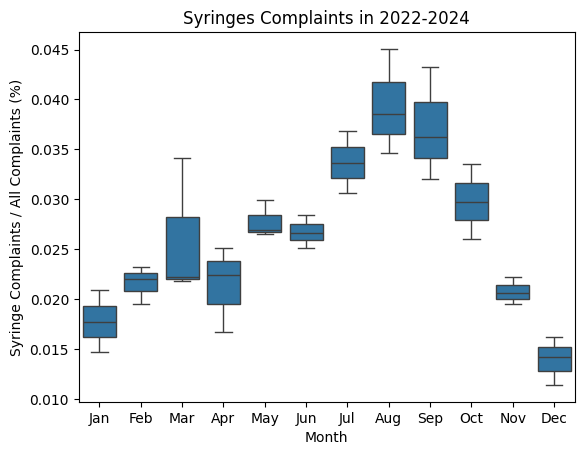

In [4]:
# Group the 311 complaints by month and year
# Count all of the complaints and the syringe-related complaints
complaints_by_month = all_311_complaints.groupby(['created_month', 'created_year']).agg(all_complaints = ('descriptor', 'count'),
                                                                                        syringe_complaints = ('descriptor', lambda x: (x == 'Syringes').sum()))

# Calculate syringe complaints as a percentage of total complaints
complaints_by_month['syringes/all (%)'] = 100 * complaints_by_month['syringe_complaints'] / complaints_by_month['all_complaints']

# Plot syringe complaints (%) by month
order = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
ax = sns.boxplot(data = complaints_by_month,
                 x = 'created_month',
                 y = 'syringes/all (%)',
                 order = order)
ax.set_xlabel('Month')
ax.set_ylabel('Syringe Complaints / All Complaints (%)')
plt.title('Syringes Complaints in 2022-2024')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

In [5]:
# Load map of NYC for plotting, CRS = 2263 (NAD83 / New York Long Island (ftUS))
nyc = gpd.read_file(geodatasets.get_path('nybb'))

Extracting 'nybb_16a/nybb.shp' from '/root/.cache/geodatasets/nybb_16a.zip' to '/root/.cache/geodatasets/nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.shx' from '/root/.cache/geodatasets/nybb_16a.zip' to '/root/.cache/geodatasets/nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.dbf' from '/root/.cache/geodatasets/nybb_16a.zip' to '/root/.cache/geodatasets/nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.prj' from '/root/.cache/geodatasets/nybb_16a.zip' to '/root/.cache/geodatasets/nybb_16a.zip.unzip'


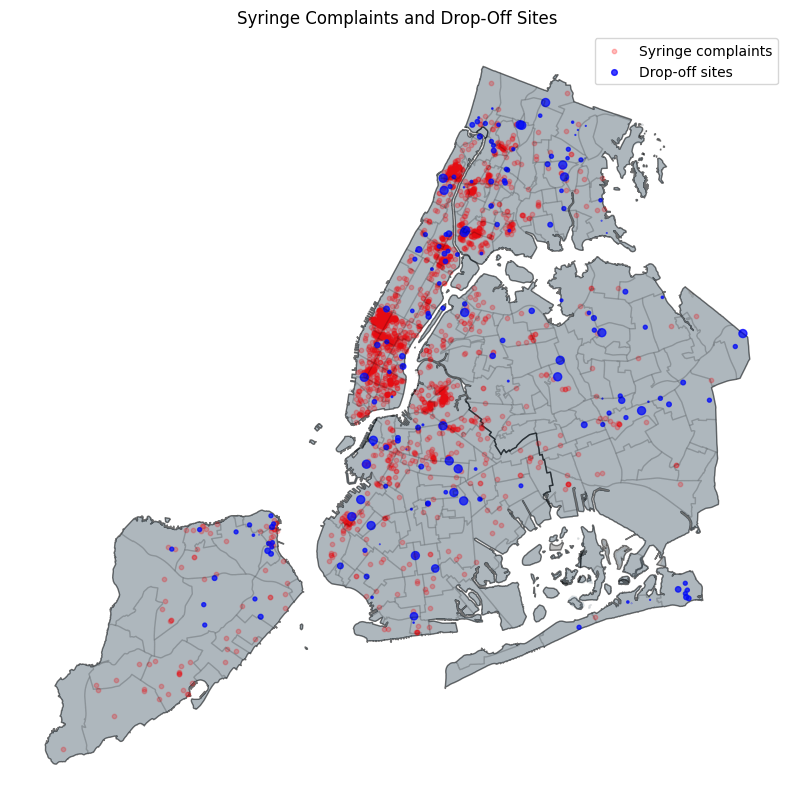

In [6]:
# Plot the syringe complaints, dropoff sites, and NTAs on a map of NYC
fig, ax = plt.subplots(figsize = (10, 10))

# Plot the map of NYC
nyc.plot(ax = ax, alpha = 0.5, color = 'gray', edgecolor = 'k')

# Plot the syringe complaints
all_311_complaints[all_311_complaints['descriptor']=='Syringes'].plot(ax = ax, markersize = 10, alpha = 0.25, color = 'red')

# Plot the dropoff sites
dropoff_sites.plot(ax = ax, markersize = dropoff_sites['hours_per_month']*0.05, alpha = 0.75, color = 'blue')

# Plot the NTAs
nta.plot(ax = ax, edgecolor = 'k', alpha = 0.1)

# Format the plot
ax.set_axis_off()
ax.legend(['Syringe complaints', 'Drop-off sites'])
plt.title('Syringe Complaints and Drop-Off Sites')
plt.show()

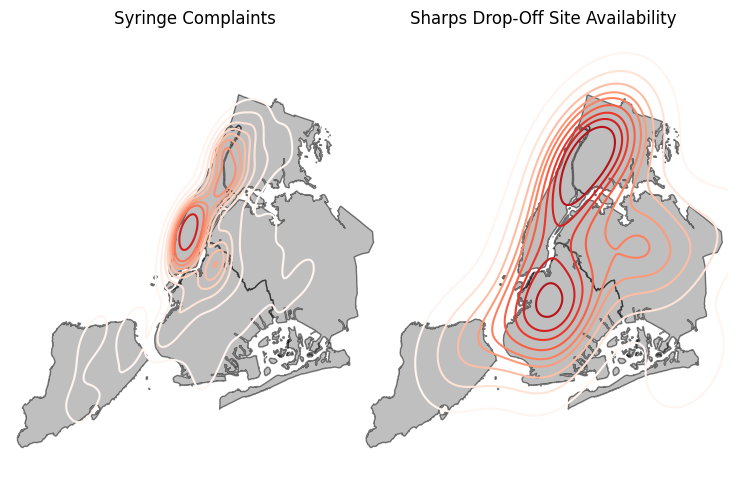

In [7]:
# Plot dropoff locations and syringe locations side by side
fig, axes = plt.subplots(1, 2, figsize = (12, 6))

# Plot syringe complaints on one subplot
subplot1 = nyc.plot(ax = axes[0], alpha = 0.5, color = 'gray', edgecolor = 'k')
sns.kdeplot(x = all_311_complaints[all_311_complaints['descriptor']=='Syringes'].geometry.x,
            y = all_311_complaints[all_311_complaints['descriptor']=='Syringes'].geometry.y,
            cmap = 'Reds',
            ax=axes[0])

# Plot dropoff sites on the other subplot
subplot2 = nyc.plot(ax = axes[1], alpha = 0.5, color = 'gray', edgecolor = 'k')
sns.kdeplot(x = dropoff_sites.geometry.x, y = dropoff_sites.geometry.y,
            weights = dropoff_sites['hours_per_month']/672,
            cmap = 'Reds',
            ax=axes[1])

# Format the plot
subplot1.set_axis_off()
subplot2.set_axis_off()

# Set x and y limits
axes[0].set_xlim(0.91e6, 1.07e6)
axes[0].set_ylim(100000, 300000)
axes[1].set_xlim(0.91e6, 1.07e6)
axes[1].set_ylim(100000, 300000)

# Title each subplot and adjust the spacing
axes[0].set_title('Syringe Complaints')
axes[1].set_title('Sharps Drop-Off Site Availability')
plt.subplots_adjust(wspace = -0.4)
plt.show()

In [8]:
# Remove 311 complaints with no latitude and longitude data
all_311_complaints = all_311_complaints.dropna(subset = ['latitude', 'longitude'])
all_311_complaints.reset_index(drop = True, inplace = True)

In [9]:
# Do a spatial join to find the NTA associated with each 311 complaint
all_311_complaints = all_311_complaints.sjoin(nta[['NTA2020', 'geometry']], how = 'left')

In [49]:
# Group the complaints by NTA
# Count all of the complaints and the syringe-related complaints
all = all_311_complaints.groupby('NTA2020').agg(all = ('unique_key', 'count')).sort_values(by = 'NTA2020').values
syringes = all_311_complaints.groupby('NTA2020').agg(syringes = ('descriptor', lambda x: (x == 'Syringes').sum())).sort_values(by = 'NTA2020').values

# Loop through each complaint type
for complaint in list(set(all_311_complaints['complaint_type'])):

  # Count the number of complaints for this complaint type
  other = all_311_complaints.groupby('NTA2020').agg(other = ('complaint_type', lambda x: (x == complaint).sum())).sort_values(by = 'NTA2020').values

  # Calculate the  correlation between the proportion of syringe complaints and the proportion of this other complaint type
  test_corr = stats.pearsonr(syringes/all, other/all)

  # If the correlation coefficient is greater than 0.4 and the p-value less than 0.05, print the complaint type
  if (test_corr[0] > 0.4) & (test_corr[1] < 0.05):
    print(complaint, test_corr)

Homeless Person Assistance PearsonRResult(statistic=array([0.42983733]), pvalue=array([3.31744446e-13]))
Panhandling PearsonRResult(statistic=array([0.5011319]), pvalue=array([4.59060017e-18]))
Squeegee PearsonRResult(statistic=array([0.5048364]), pvalue=array([2.38289929e-18]))
Encampment PearsonRResult(statistic=array([0.45175466]), pvalue=array([1.3987957e-14]))


In [10]:
# Group all_311_complaints by NTA and count the following:
# All complaints
# Syringe complaints
# Encampment complaints
# Homeless Person Assistance complaints
# Panhandling complaints
# Squeegee complaints
complaints_by_nta = all_311_complaints.groupby('NTA2020').agg(all_complaints = ('unique_key', 'count'),
                                                              syringe_complaints = ('descriptor', lambda x: (x == 'Syringes').sum()),
                                                              encampment_complaints = ('complaint_type', lambda x: (x == 'Encampment').sum()),
                                                              homeless_assistance_complaints = ('complaint_type', lambda x: (x == 'Homeless Person Assistance').sum()),
                                                              panhandling_complaints = ('complaint_type', lambda x: (x == 'Panhandling').sum()),
                                                              squeegee_complaints = ('complaint_type', lambda x: (x == 'Squeegee').sum()))
complaints_by_nta.reset_index(inplace = True)

In [11]:
# Divide each category by all_complaints
complaints_by_nta['syringes/all (%)'] = 100 * complaints_by_nta['syringe_complaints'] / complaints_by_nta['all_complaints']
complaints_by_nta['encampments/all (%)'] = 100 * complaints_by_nta['encampment_complaints'] / complaints_by_nta['all_complaints']
complaints_by_nta['homeless assistance/all (%)'] = 100 * complaints_by_nta['homeless_assistance_complaints'] / complaints_by_nta['all_complaints']
complaints_by_nta['panhandling/all (%)'] = 100 * complaints_by_nta['panhandling_complaints'] / complaints_by_nta['all_complaints']
complaints_by_nta['squeegee/all (%)'] = 100 * complaints_by_nta['squeegee_complaints'] / complaints_by_nta['all_complaints']

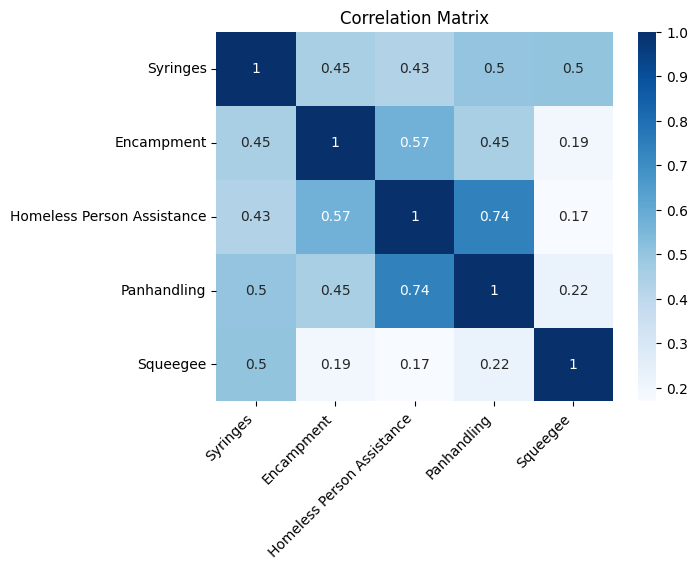

In [12]:
# Plot the correlation matrix between the proportion of syringe complaints and the proportion of the other complaint categories
fig, ax = plt.subplots()
sns.heatmap(complaints_by_nta[['syringes/all (%)',
                               'encampments/all (%)',
                               'homeless assistance/all (%)',
                               'panhandling/all (%)',
                               'squeegee/all (%)']].corr(),
            cmap = 'Blues', annot = True)
ax.set_title('Correlation Matrix')
ax.set_xticklabels(['Syringes', 'Encampment', 'Homeless Person Assistance', 'Panhandling', 'Squeegee'], rotation = 45, ha = 'right')
ax.set_yticklabels(['Syringes', 'Encampment', 'Homeless Person Assistance', 'Panhandling', 'Squeegee'])
plt.show()

# Feature engineering

In [14]:
# Convert "NTAType" into dummy variables
nta[['airport', 'cemetery', 'other', 'park', 'residential']] = pd.get_dummies(nta['NTAType'], dtype = 'Int64')

In [15]:
# Merge complaints_by_nta with nta
complaints_by_nta = complaints_by_nta.merge(nta[['NTA2020', 'BoroName', 'area_sq_mi', 'Pop_1E', 'CvLFUEm1P', 'MdHHIncE',
                                                 'PvU50P', 'Pv500plP', 'VacHUP', 'ROcHU1P', 'GRPI30plP', 'airport',
                                                 'cemetery', 'park', 'residential', 'other']], on = 'NTA2020')

In [16]:
complaints_by_nta.head(2)

,NTA2020,all_complaints,syringe_complaints,encampment_complaints,homeless_assistance_complaints,panhandling_complaints,squeegee_complaints,syringes/all (%),encampments/all (%),homeless assistance/all (%),...,PvU50P,Pv500plP,VacHUP,ROcHU1P,GRPI30plP,airport,cemetery,park,residential,other
0,BK0101,60778,29,381,385,202,0,0.047715,0.626872,0.633453,...,4.1,52.8,8.0,82.2,35.1,0,0,0,1,0
1,BK0102,75546,48,931,702,272,0,0.063537,1.232362,0.929235,...,7.1,46.6,7.4,83.1,42.0,0,0,0,1,0


In [17]:
# For each NTA, generate 100 random points
nta_random_points = gpd.GeoDataFrame()
nta_random_points['NTA2020'] = nta['NTA2020']
nta_random_points['random_points'] = nta['geometry'].sample_points(100, method='uniform', rng = 212)
nta_random_points = nta_random_points.set_index('NTA2020')
nta_random_points = nta_random_points['random_points'].explode(ignore_index = False).reset_index()

In [18]:
# For each random point, calculate the distance to the nearest drop-off site
nta_random_points['nearest_dropoff_dist_ft'] = nta_random_points['random_points'].apply(lambda x: dropoff_sites.distance(x).min()).round(0)
nta_random_points['nearest_dropoff_dist_mi'] = nta_random_points['nearest_dropoff_dist_ft'] / 5280

# For each random point, calculate the distance to the nearest drop-off site,
# but only include drop-off sites open at least 336 hours per month
dropoff_sites_336h = dropoff_sites[dropoff_sites['hours_per_month'] >= 336]
nta_random_points['nearest_available_dropoff_dist_ft'] = nta_random_points['random_points'].apply(lambda x: dropoff_sites_336h.distance(x).min()).round(0)
nta_random_points['nearest_available_dropoff_dist_mi'] = nta_random_points['nearest_available_dropoff_dist_ft'] / 5280

# For each random point, calculate the distance to Times Square
times_square = pd.DataFrame({'longitude': [-73.985130], 'latitude': [40.758896]})
times_square = gpd.points_from_xy(times_square.longitude, times_square.latitude, crs = 'EPSG:4326').to_crs(epsg=2263)
nta_random_points['times_square_dist_ft'] = nta_random_points['random_points'].apply(lambda x: times_square.distance(x).mean()).round(0)
nta_random_points['times_square_dist_mi'] = nta_random_points['times_square_dist_ft'] / 5280

# Group nta_random_points by NTA and calculate the average
nta_random_points = nta_random_points.groupby('NTA2020').agg(nearest_dropoff_dist_mi = ('nearest_dropoff_dist_mi', 'mean'),
                                                             nearest_available_dropoff_dist_mi = ('nearest_available_dropoff_dist_mi', 'mean'),
                                                             times_square_dist_mi = ('times_square_dist_mi', 'mean')).reset_index()

In [19]:
# Merge complaints_by_nta with nta_random_points
complaints_by_nta = complaints_by_nta.merge(nta_random_points[['NTA2020', 'nearest_dropoff_dist_mi',
                                                               'nearest_available_dropoff_dist_mi', 'times_square_dist_mi']],
                                            on = 'NTA2020')

In [20]:
# Join hotels with nta and then group by NTA2020 to find the number of hotels in each NTA
hotels = gpd.sjoin(hotels, nta[['NTA2020', 'geometry', 'area_sq_mi']], how = 'left')
hotels_by_nta = hotels.groupby('NTA2020').agg(hotel_count = ('parid', 'count'),
                                           nta_area = ('area_sq_mi', 'mean')).reset_index()

In [21]:
# Calculate the hotels per square mile
hotels_by_nta['hotels_per_sq_mi'] = hotels_by_nta['hotel_count'] / hotels_by_nta['nta_area']

In [22]:
# Merge complaints_by_nta with hotels_by_nta
complaints_by_nta = complaints_by_nta.merge(hotels_by_nta[['NTA2020', 'hotels_per_sq_mi']], how = 'left', on = 'NTA2020')

In [23]:
# Convert "BoroName" into dummy variables
complaints_by_nta[['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']] = pd.get_dummies(complaints_by_nta['BoroName'], dtype = 'Int64')

In [24]:
# Drop "BoroName"
complaints_by_nta.drop(columns = 'BoroName', inplace = True)

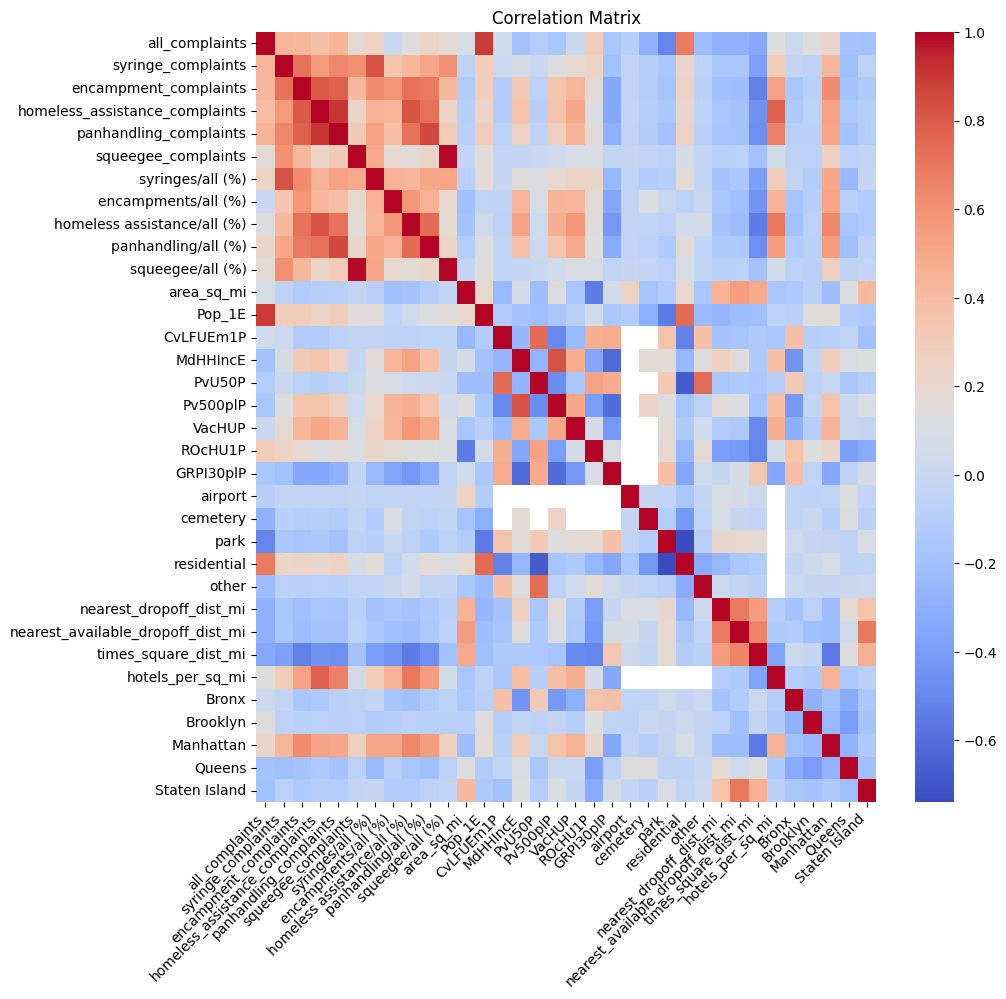

In [27]:
# View the correlation matrix
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(complaints_by_nta[complaints_by_nta.columns[1:]].corr(), ax = ax, cmap = 'coolwarm');
ax.set_title('Correlation Matrix');
ax.set_xticklabels(labels = complaints_by_nta.columns[1:], rotation = 45, ha = 'right');

In [26]:
# Save complaints_by_nta as a .pkl file
complaints_by_nta.to_pickle('complaints_by_nta.pkl')

# Modeling

In [29]:
# View missing values
complaints_by_nta.isna().sum()

,0
NTA2020,0
all_complaints,0
syringe_complaints,0
encampment_complaints,0
homeless_assistance_complaints,0
panhandling_complaints,0
squeegee_complaints,0
syringes/all (%),0
encampments/all (%),0
homeless assistance/all (%),0


In [53]:
# Choose the X and y variables
X_var_names = ['all_complaints', 'encampment_complaints', 'homeless_assistance_complaints',
               'panhandling_complaints', 'squeegee_complaints', 'area_sq_mi', 'Pop_1E',
               'CvLFUEm1P', 'MdHHIncE', 'PvU50P', 'Pv500plP', 'VacHUP', 'ROcHU1P',
               'GRPI30plP', 'nearest_dropoff_dist_mi', 'nearest_available_dropoff_dist_mi',
               'times_square_dist_mi', 'hotels_per_sq_mi',
               'airport', 'cemetery', 'park', 'residential', 'other',
               'Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']

X = complaints_by_nta[X_var_names]

y = complaints_by_nta[['syringe_complaints']]

# Replace NaN with 0 in X
X = X.fillna(0)

# Split the data into train, test, and val sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 212)

In [57]:
# Normalize the train, test, and val data based on the train data
X_mean = X_train.mean()
X_std = X_train.std()
X_train_norm = (X_train - X_mean) / X_std
X_test_norm = (X_test - X_mean) / X_std

y_mean = y_train.mean()
y_std = y_train.std()
y_train_norm = (y_train - y_mean) / y_std
y_test_norm = (y_test - y_mean) / y_std

In [58]:
np.logspace(-2, 2, 20)

array([1.00000000e-02, 1.62377674e-02, 2.63665090e-02, 4.28133240e-02,
       6.95192796e-02, 1.12883789e-01, 1.83298071e-01, 2.97635144e-01,
       4.83293024e-01, 7.84759970e-01, 1.27427499e+00, 2.06913808e+00,
       3.35981829e+00, 5.45559478e+00, 8.85866790e+00, 1.43844989e+01,
       2.33572147e+01, 3.79269019e+01, 6.15848211e+01, 1.00000000e+02])

In [59]:
# Define a grid of hyperparameters for ElasticNet regularization
# 'alpha' controls overall regularization strength
# 'l1_ratio' balances L1 (Lasso) and L2 (Ridge) regularization
param_grid = {'alpha': np.logspace(-2, 2, 20),
              'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}

# Initialize an ElasticNet regression model
linear_model = ElasticNet(random_state = 212)

# Use grid search to find the best combination of hyperparameters, based on R2
grid_search = GridSearchCV(linear_model, param_grid, cv = 5, scoring='r2')

# Fit the model to the training data
grid_search.fit(X_train_norm, y_train_norm)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Get the best model
best_linear_model = grid_search.best_estimator_

# Predict on the normalized test set
y_pred_norm = best_linear_model.predict(X_test_norm)

# De-normalize the predictions
y_pred = y_pred_norm * y_std.values + y_mean.values

# Print the mean squared error and R2 of the best model
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('R2:', metrics.r2_score(y_test, y_pred))

# Print the regression coefficients for each predictor variable
for i, coef in enumerate(best_linear_model.coef_):
  print(f'{X_var_names[i]}, coef = {coef}')

Best hyperparameters: {'alpha': np.float64(0.7847599703514611), 'l1_ratio': 0.1}
Mean Squared Error: 37.62227862128347
R2: 0.7757242404720076
all_complaints, coef = 0.07088138449227573
encampment_complaints, coef = 0.18916627977229383
homeless_assistance_complaints, coef = 0.05797477154957057
panhandling_complaints, coef = 0.13677214181232925
squeegee_complaints, coef = 0.22011582989973205
area_sq_mi, coef = 0.0
Pop_1E, coef = 0.0
CvLFUEm1P, coef = 0.0
MdHHIncE, coef = 0.0
PvU50P, coef = 0.0
Pv500plP, coef = 0.0
VacHUP, coef = 0.0
ROcHU1P, coef = 0.007449498245671482
GRPI30plP, coef = 0.0
nearest_dropoff_dist_mi, coef = -0.0
nearest_available_dropoff_dist_mi, coef = -0.0
times_square_dist_mi, coef = -0.021870321296230035
hotels_per_sq_mi, coef = 0.0
airport, coef = -0.0
cemetery, coef = -0.0
park, coef = -0.0
residential, coef = 0.0
other, coef = -0.0
Bronx, coef = 0.0
Brooklyn, coef = -0.0
Manhattan, coef = 0.026004934437790193
Queens, coef = -0.011775973750806565
Staten Island, coef 

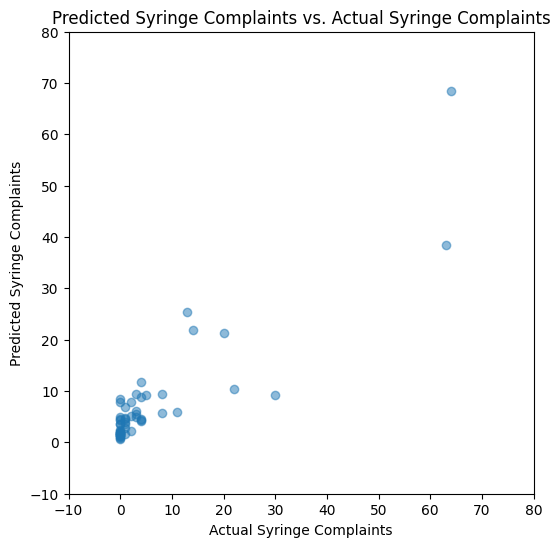

In [70]:
# Plot y_pred vs y_test
fig, ax = plt.subplots(figsize = (6, 6))
ax.scatter(y_test, y_pred, alpha = 0.5)
ax.set_xlim(-10, 80)
ax.set_ylim(-10, 80)
ax.set_title('Predicted Syringe Complaints vs. Actual Syringe Complaints')
ax.set_xlabel('Actual Syringe Complaints')
ax.set_ylabel('Predicted Syringe Complaints')
plt.show()